# Introduction to NLP at Karakun
## Part 1 - baselines, confusion matrix

As an example task throughout this training we use a dataset for sentiment analysis. This dataset contains reviews from the movie plattform **IMDb**. These reviews are labeled as **positive** or **negative**. Our goal for the following tasks is to predict the sentiment of a given review.

Work through this notebook from top to bottom and execute the cells with code. A lot of the code is already prepared. Cells in this notebook which have to be completed with some code snippets are marked with: 

**<font color='red'>!! Call for action !!</font>**.

### Imports

In [1]:
import random
import nltk
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas
import numpy as np
from collections import Counter
import itertools
from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format='retina'

# We set a random seed to have reproducible experiments
random.seed(0)

### Define data paths

In [2]:
# Train
train_pos_path = './Sentiment-Analysis-Data/imdb/train-pos.txt'
train_neg_path = './Sentiment-Analysis-Data/imdb/train-neg.txt'

# Test
test_pos_path = './Sentiment-Analysis-Data/imdb/test-pos.txt'
test_neg_path = './Sentiment-Analysis-Data/imdb/test-neg.txt'

### Read data

Here we read the reviews from textfiles. All reviews are written into a list as a **tuple** together with their sentiment.

In [3]:
def read_split_reviews_from_file(file_path, sentiment):
    reviews = []
    
    with open(file_path, 'r') as f:
        for line in f:
            # split text into single words and remove words with length smaller than 2
            review_splitted = [e.lower() for e in line.split() if len(e) >= 2]
            reviews.append((review_splitted, sentiment))
            
    return reviews

In [4]:
# Train
train_reviews_pos = read_split_reviews_from_file(train_pos_path, 'pos')
train_reviews_neg = read_split_reviews_from_file(train_neg_path, 'neg')

# Test
test_reviews_pos = read_split_reviews_from_file(test_pos_path, 'pos')
test_reviews_neg = read_split_reviews_from_file(test_neg_path, 'neg')

In [5]:
# Concatenate positive and negative reviews
train_reviews = train_reviews_pos + train_reviews_neg
test_reviews = test_reviews_pos + test_reviews_neg

In [6]:
# Check sizes of dataset
print(f'Train size:\t{len(train_reviews)} \nTest size:\t{len(test_reviews)}')

Train size:	25000 
Test size:	25000


Every tuple contains the splitted review as a **list of words** and the sentiment as a **string**.

In [7]:
# Check single sample
INDEX = 230
print(f'> Splitted text:\n================\n{train_reviews[INDEX][0][:40]} \n\n> Sentiment:\n================\n{train_reviews[INDEX][1]}')

> Splitted text:
['this', 'film', 'has', 'renewed', 'my', 'interest', 'in', 'french', 'cinema', 'the', 'story', 'is', 'enchanting', 'the', 'acting', 'is', 'flawless', 'and', 'audrey', 'tautou', 'is', 'absolutely', 'beautiful', 'imagine', 'that', 'we', 'will', 'be', 'seeing', 'lot', 'more', 'of', 'her', 'in', 'the', 'states', 'after', 'her', 'upcoming', 'role'] 

> Sentiment:
pos


In [8]:
# Shuffle the train and test datasets
random.shuffle(train_reviews)
random.shuffle(test_reviews)

In [9]:
# Check the sample at the same index again
INDEX = 230
print(f'> Splitted text:\n================\n{train_reviews[INDEX][0][:40]} \n\n> Sentiment:\n================\n{train_reviews[INDEX][1]}')

> Splitted text:
['judy', 'davis', 'shows', 'us', 'here', 'why', 'she', 'is', 'one', 'of', 'australia', 'most', 'respected', 'and', 'loved', 'actors', 'her', 'portrayal', 'of', 'lonely', 'directionless', 'nomad', 'is', 'first', 'rate', 'teenaged', 'claudia', 'karvan', 'also', 'gives', 'us', 'glimpse', 'of', 'what', 'would', 'make', 'her', 'one', 'of', 'this'] 

> Sentiment:
pos


Further split our test set into a evaluation set and a real test set. This will be relevant for future tasks...

In [10]:
N_test= int(len(test_reviews)/2)

eval_reviews = test_reviews[:N_test]
test_reviews = test_reviews[N_test:]

In [11]:
# Check sizes of dataset
print(f'Train size:\t{len(train_reviews)} \nEval size:\t{len(eval_reviews)} \nTest size:\t{len(test_reviews)}')

Train size:	25000 
Eval size:	12500 
Test size:	12500


### Data exploration on our training set

Let's look if our data holds Zipf's law with the help of the **FreqDist** function of NLTK:

In [12]:
all_words = []
for (words, sentiment) in train_reviews+eval_reviews+test_reviews:
    all_words.extend(words)
    
wordlist = nltk.FreqDist(all_words)

In [36]:
print(f'All words in the reviews: \t{len(all_words)}')
print(f'Size of dictionary: \t\t{len(wordlist)}')

All words in the reviews: 	10977368
Size of dictionary: 		100641


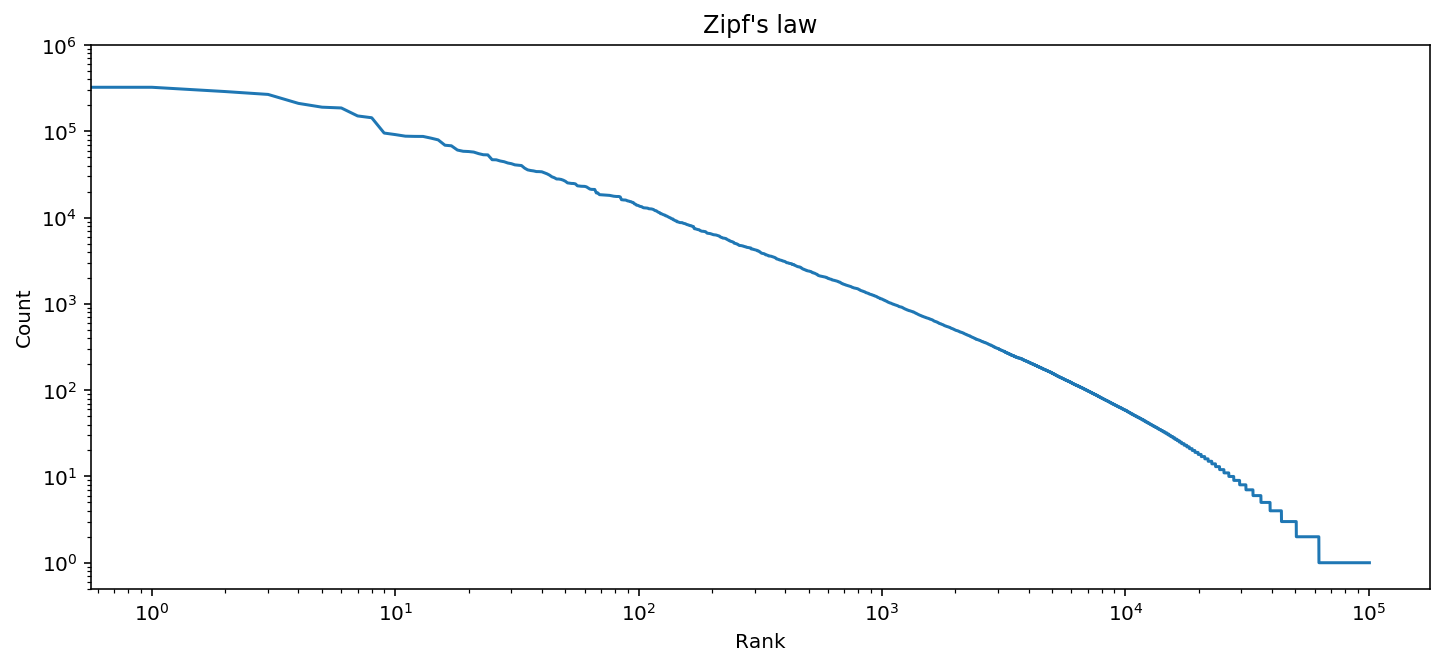

In [13]:
frequencies = []
for token,freq in wordlist.items():
    frequencies.append(freq)

# plot results
plt.figure(figsize=(12,5))
plt.plot(sorted(frequencies, reverse=True))
plt.title("Zipf's law")
plt.xlabel('Rank')
plt.xscale('log')
plt.ylabel('Count')
plt.yscale('log')
plt.ylim([0.5,1e6])
plt.show()

What are the most common words?

In [14]:
wordlist.most_common(10)

[('the', 667875),
 ('and', 324436),
 ('of', 289410),
 ('to', 268122),
 ('is', 211079),
 ('it', 190713),
 ('in', 186780),
 ('this', 151001),
 ('that', 143844),
 ('was', 95608)]

Let's see how our classes (positive and negative) are distributed in our training set...

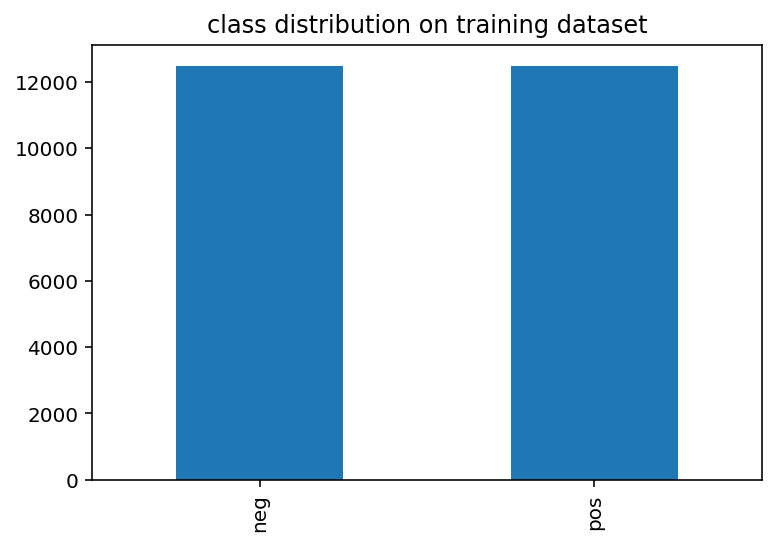

In [15]:
train_sentiments = [sent for (_, sent) in train_reviews ] 
sentiment_counts = Counter(train_sentiments)

_ = pandas.Series(Counter(train_sentiments)).plot(kind='bar', title='class distribution on training dataset')

### Build some baseline classifiers

The two easiest baseline models for a classification task are random classifiers and constant classifiers. Usually a constant classifier would be a majority classifier where we take the class with the most samples. In this case because we have a perfectly balanced class distribution we can choose the constant by ourselves.

In [16]:
# get the true values of our test dataset
gold = [sent for (_, sent) in test_reviews ]

print(f'Sentiments of the 5 first elements in the testset:\n================\n{gold[:5]}\n')

Sentiments of the 5 first elements in the testset:
['neg', 'neg', 'pos', 'neg', 'neg']



Our goal is to predict these sentiments. For our baseline models we are currently not interested in the actual review. We simply ignore them.

Let's build these two baseline:

In [17]:
def constant_baseline(count, constant):
    pred = []
    
    for i in range(count):
        pred.append(constant)
    
    return pred

In [18]:
constant_pred = constant_baseline(len(gold), 'pos')
print(f'Sentiments of the 5 first elements in the prediction:\n================\n{constant_pred[:5]}\n')

Sentiments of the 5 first elements in the prediction:
['pos', 'pos', 'pos', 'pos', 'pos']



## <font color='red'>!! **Start** - Call for action !!</font>

In [19]:
def random_baseline(count):
    pred = []
    
    # TODO : Implement a random classifier
    
    sentiments = ['pos', 'neg']
    
    for i in range(count):
        pred.append(random.choice(sentiments))
    
    # TODO: end
    
    return pred

## <font color='red'>!! **End** - Call for action !!</font>

In [20]:
random_pred = random_baseline(len(gold))
print(f'Sentiments of the 5 first elements in the prediction:\n================\n{random_pred[:5]}\n')

Sentiments of the 5 first elements in the prediction:
['neg', 'pos', 'pos', 'pos', 'pos']



### Confusion matrix

The library **NLTK** for example already has a function to calculate the confusion matrix.

In [21]:
cm_constant_baseline = nltk.ConfusionMatrix(gold, constant_pred)

print(cm_constant_baseline.pretty_format(sort_by_count=True, show_percents=False, truncate=9))
print()
print(cm_constant_baseline.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

    |    p    n |
    |    o    e |
    |    s    g |
----+-----------+
pos |<6253>   . |
neg | 6247   <.>|
----+-----------+
(row = reference; col = test)


    |      p      n |
    |      o      e |
    |      s      g |
----+---------------+
pos | <50.0%>     . |
neg |  50.0%     <.>|
----+---------------+
(row = reference; col = test)



In [22]:
cm_random_baseline = nltk.ConfusionMatrix(gold, random_pred)

print(cm_random_baseline.pretty_format(sort_by_count=True, show_percents=False, truncate=9))
print()
print(cm_random_baseline.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

    |    p    n |
    |    o    e |
    |    s    g |
----+-----------+
pos |<3139>3114 |
neg | 3135<3112>|
----+-----------+
(row = reference; col = test)


    |      p      n |
    |      o      e |
    |      s      g |
----+---------------+
pos | <25.1%> 24.9% |
neg |  25.1% <24.9%>|
----+---------------+
(row = reference; col = test)



Let's build our own method to calculate the confusion matrix. As inputs we have a list of our gold standard (**true_values**) and a list of our predictions (**pred_values**):

## <font color='red'>!! **Start** - Call for action !!</font>

In [23]:
def calculate_confusion_matrix(true_values, pred_values):
    
    if len(true_values) != len(pred_values):
        raise ValueError("Lists must have the same length.")
    
    # Get distinct classes
    classes = list(set(true_values + pred_values))
    n_classes = len(classes)
    
    # Create new matrix with zero values with shape (n_classes, n_classes) - (2, 2)
    # Row     (1st dimension): true values
    # Column  (2nd dimension): predicted values
    cm = np.zeros((n_classes, n_classes))
    
    for (true, pred) in zip(true_values, pred_values):
        
        # TODO : Complete the calculation for the confusion matrix
                
        row = classes.index(true)
        column = classes.index(pred)
        
        cm[row, column] += 1
        
        # TODO : end
        
    return cm, classes

## <font color='red'>!! **End** - Call for action !!</font>

In [24]:
cm_random, classes_random = calculate_confusion_matrix(gold, random_pred)

print(cm_random)
print()
print(f'Classes {classes_random}')

[[3139. 3114.]
 [3135. 3112.]]

Classes ['pos', 'neg']


In [25]:
cm_constant, classes_constant = calculate_confusion_matrix(gold, constant_pred)

print(cm_constant)
print()
print(f'Classes {classes_constant}')

[[6253.    0.]
 [6247.    0.]]

Classes ['pos', 'neg']


The calculated confusion matrices should be identical to the absolute values of the NLTK implementation or mirrored if the classes are not ordered the same.

Next we define a method to beautifully plot our confusion matrix:

In [26]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix'):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt = plt.text(j, i, "{:d}\n({:0.4f})".format(int(cm[i, j]), cm_normalized[i, j]),
                     horizontalalignment="center",
                     color="white")
            
        txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

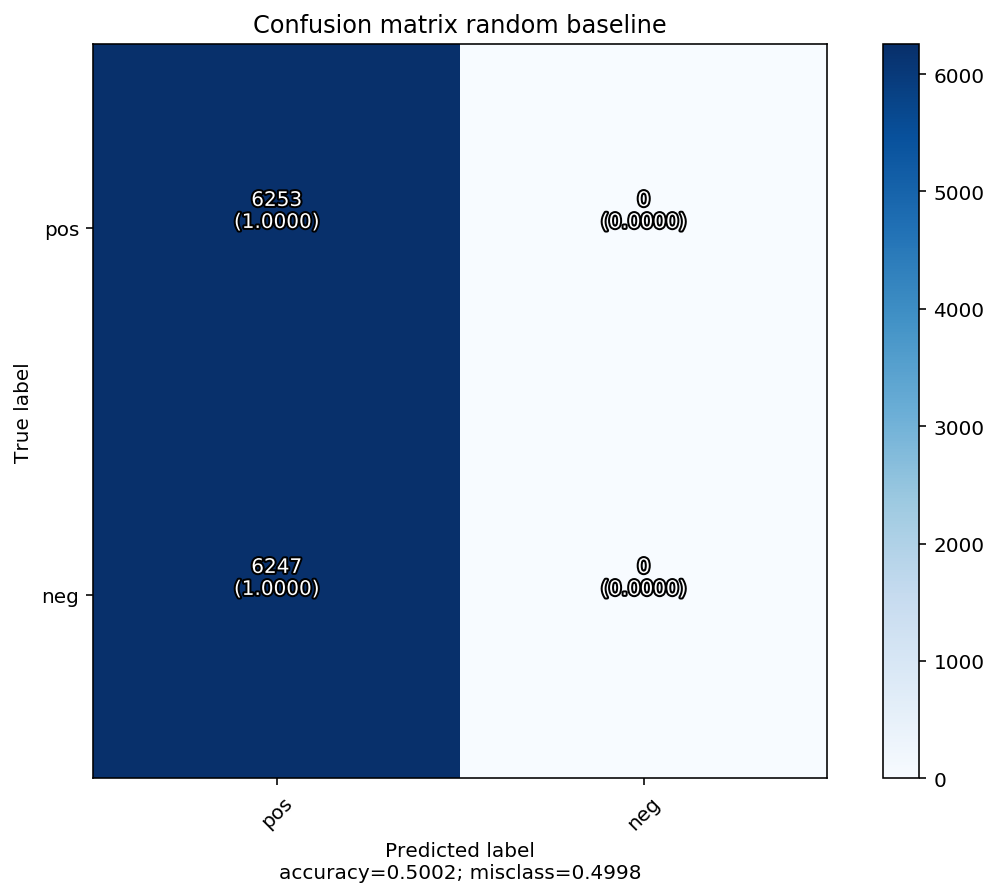

In [27]:
plot_confusion_matrix(cm_constant, classes_constant, title='Confusion matrix random baseline')

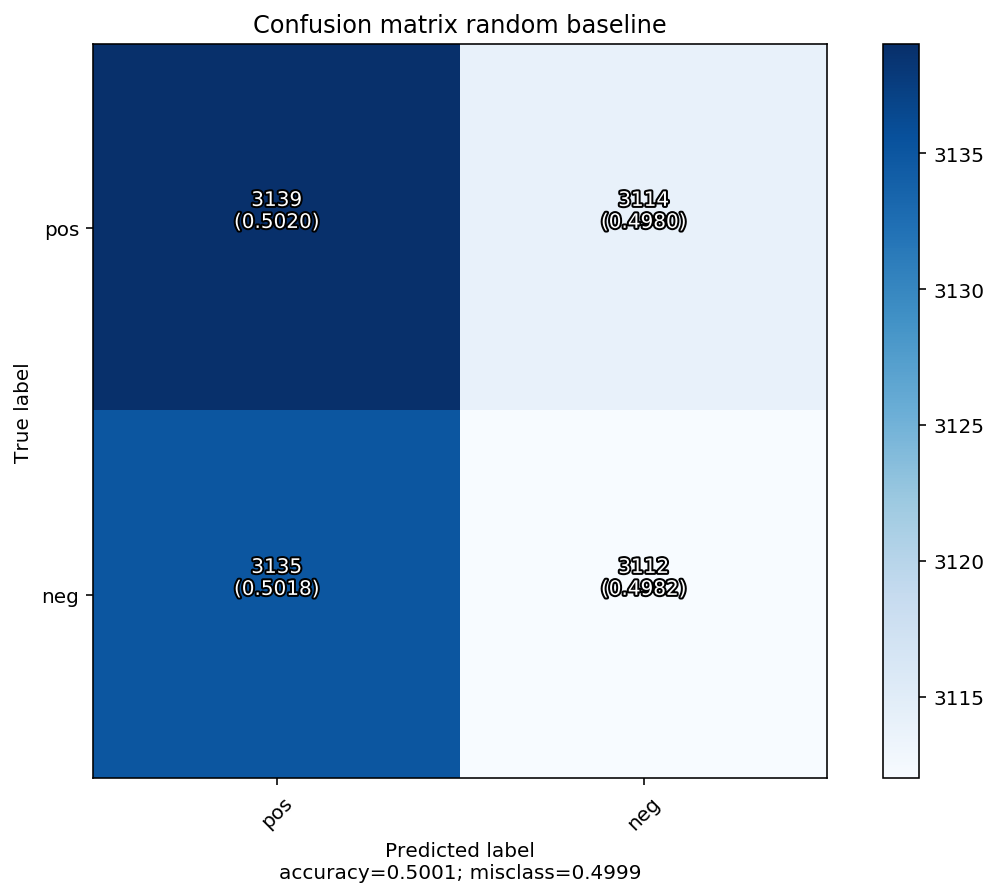

In [28]:
plot_confusion_matrix(cm_random, classes_random, title='Confusion matrix random baseline')

### Build a more sophisticated baseline - AFINN-111

The **AFINN-111** dataset contains 2477 English words and phrases rated with an integer between -5 and +5. The higher the number the more positive the term is. Terms with a score of 0 are neutral. 

In [29]:
sentiment_dict = defaultdict(int)
for line in open('./Sentiment-Analysis-Data/AFINN/AFINN-111.txt'):
    word,sent = line.split('\t')
    sentiment_dict[word] = int(sent)

In [30]:
print(f'Some examples: \n{list(sentiment_dict.items())[:10]} \n')

sample_words = ['awesome','awful','bad','badly','better','excellent','good','great','horrible','like','lol','very','terrible','woods','wow']

for w in sample_words:
    print(" %10s : %3d" % (w, sentiment_dict[w]))

Some examples: 
[('abandon', -2), ('abandoned', -2), ('abandons', -2), ('abducted', -2), ('abduction', -2), ('abductions', -2), ('abhor', -3), ('abhorred', -3), ('abhorrent', -3), ('abhors', -3)] 

    awesome :   4
      awful :  -3
        bad :  -3
      badly :  -3
     better :   2
  excellent :   3
       good :   3
      great :   3
   horrible :  -3
       like :   2
        lol :   3
       very :   0
   terrible :  -3
      woods :   0
        wow :   4


In [35]:
def afinn_baseline(reviews, threshold=6):
    pred = []
    
    sentiments = ['pos', 'neg']
    
    for i in range(len(reviews)):
        sentence = reviews[i]
        
        # Sum up the AFINN score of each word in the sentence
        sentiment = sum(sentiment_dict[w] for w in sentence)
        
        if sentiment > threshold:
            pred.append('pos')
        else:
            pred.append('neg')
    
    return pred

In [32]:
reviews_test = [sentence for (sentence, _) in test_reviews ]
afinn_pred = afinn_baseline(reviews_test, threshold=6)

In [33]:
cm_afinn, classes_afinn = calculate_confusion_matrix(gold, afinn_pred)

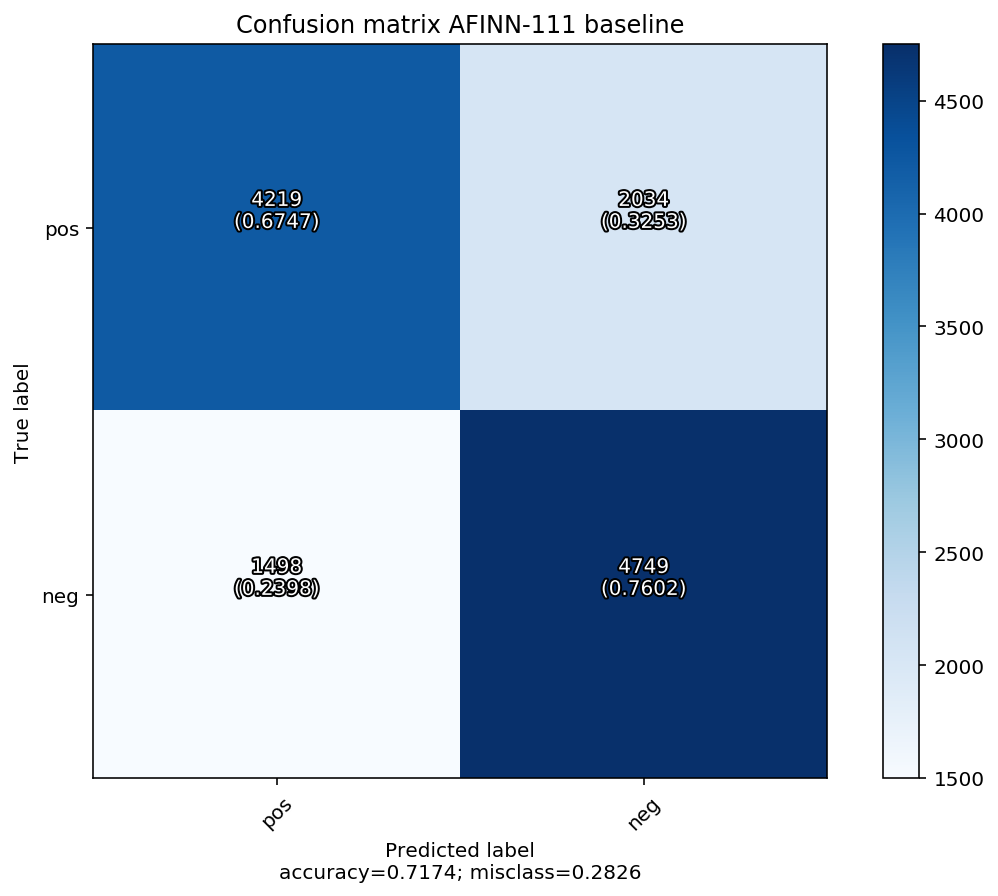

In [34]:
plot_confusion_matrix(cm_afinn, classes_afinn, title='Confusion matrix AFINN-111 baseline')

We already reached an accuracy of **over 71%** with this method. In the following exercises we try to beat this metric with Machine Learning...